In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

from lensit.clusterlens import lensingmap 

import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 

cambinifile = 'planck_2018_acc'
pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))

results = camb.get_results(pars)


In [4]:
# We define here the parameters for the profile of the cluster
M200 = 1e14
z = 1
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 128  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )

# Number of simulated maps 
nsims = 1 

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims)
print(libdir)

/Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/nfw_profile/npix128_lpix_0.3amin_lmaxsky6000/M200_1.000000E+14_z1/1_sims


In [7]:
# Instantiate the class containing the simulated maps 

clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky)


/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:90: RuntimeWarning: divide by zero encountered in arctanh
  f[xm] = 1 - 2/np.sqrt(1 - x[xm]**2) * np.arctanh(np.sqrt((1 - x[xm])/(1 + x[xm])))


Text(0.5, 0, '$\\theta \\; [\\mathrm{arcmin}]$')

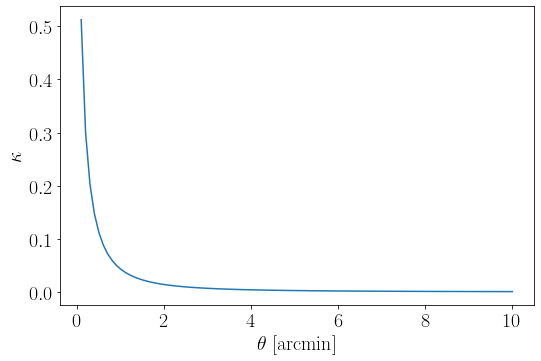

In [10]:
# We can have a look at the NFW convergence profile of our haloes

theta = np.linspace(0, 10, num=100) # Angle in arcminutes

plt.plot(theta, clustermaps.haloprofile.kappa_theta(M200, z, theta))


# plt.ylim(0, 1e-1)
plt.ylabel(r'$\kappa \, $')
plt.xlabel(r'$\theta \; [\mathrm{arcmin}]$')

Text(0, 0.5, '$\\theta \\;[\\mathrm{arcmin}]$')

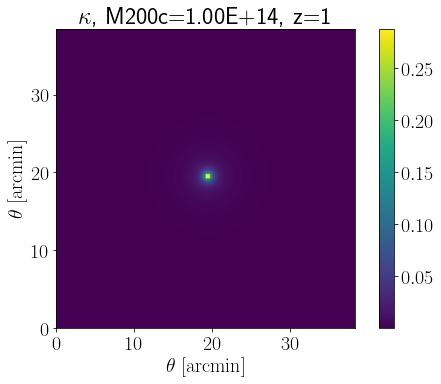

In [11]:
# And we can plot the 2D kappa map

kappamap = clustermaps.get_kappa_map(M200, z)
plt.imshow(kappamap, origin='lower', extent=[0, clustermaps.lpix_amin*clustermaps.npix, 0, clustermaps.lpix_amin*clustermaps.npix])
plt.colorbar()
plt.title(r'$\kappa$, M200c={:.2E}, z={}'.format(M200, z))
plt.xlabel(r'$\theta \;[\mathrm{arcmin}]$')
plt.ylabel(r'$\theta \;[\mathrm{arcmin}]$')



In [12]:
# You can access the lensed and unlensed CMB maps with get_len_map and get_unl_map

idx = 0 # Simulation index
field = 'u' # Access the temperature field 't', or the polarization fields 'e' or 'b'
map_unl = clustermaps.get_unl_map(idx, field)
map_len = clustermaps.get_len_map(idx, field)
map_obs = clustermaps.get_obs_map(idx, field)
# map_noise = clustermaps.get_noise_map(idx, field)


In [51]:
qmap, umap = clustermaps.maps_lib.get_sim_qumap(idx)
qlm =clustermaps.lib_skyalm.map2alm(qmap)
ulm = clustermaps.lib_skyalm.map2alm(umap)
elm, blm = clustermaps.lib_skyalm.QUlms2EBalms(np.array([qlm, ulm]))
emap = clustermaps.lib_skyalm.alm2map(elm)
bmap = clustermaps.lib_skyalm.alm2map(blm)

ls = np.where(clustermaps.ellmat.get_Nell()[:clustermaps.ellmax_sky]>0)[0]

In [42]:
elm.shape

(189,)

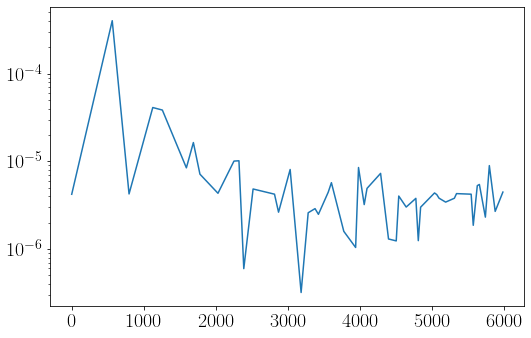

In [43]:
plt.semilogy(ls, clustermaps.lib_skyalm.map2cl(qmap)[ls])

In [44]:
clustermaps.lib_skyalm.map2alm(qmap).shape

(189,)

In [45]:
qmap.shape

(128, 128)

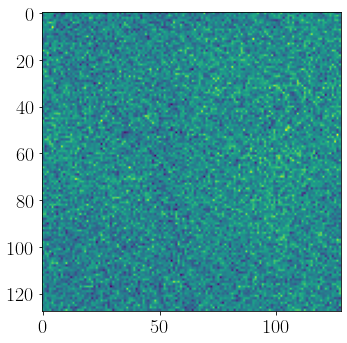

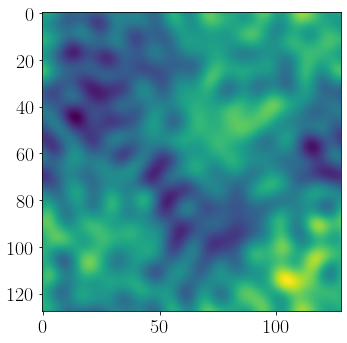

In [52]:
plt.imshow(qmap)

plt.figure()
plt.imshow(emap)


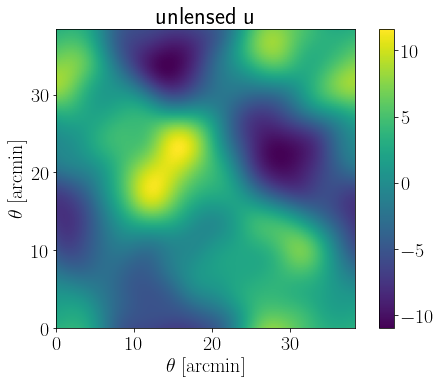

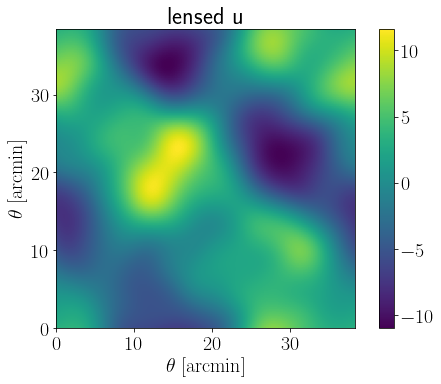

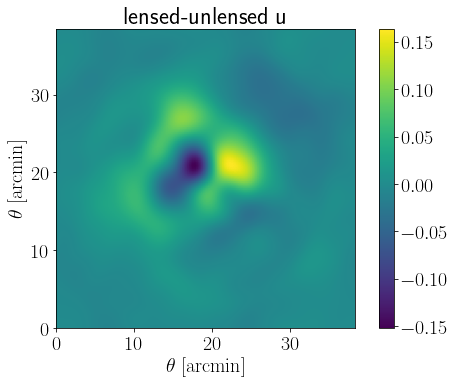

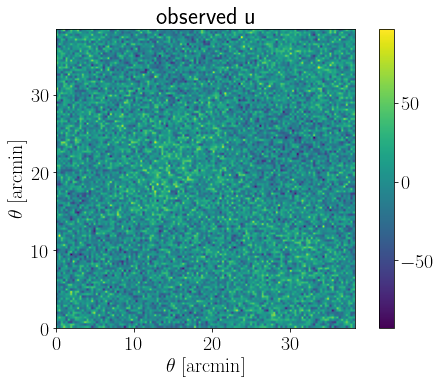

In [47]:
# for i, (mp, title) in enumerate(zip([map_unl, map_len, map_unl-map_len, map_obs, map_noise], ['unlensed', 'lensed', 'unlensed - lensed', 'observed', 'noise'])):
for i, (mp, title) in enumerate(zip([map_unl, map_len, map_len-map_unl, map_obs], ['unlensed', 'lensed', 'lensed-unlensed', 'observed'])):
    plt.figure()
    plt.imshow(mp, origin='lower', extent=[0, clustermaps.lpix_amin*clustermaps.npix, 0, clustermaps.lpix_amin*clustermaps.npix])
    plt.title(title + '  %s' % field)
    plt.xlabel(r'$\theta \;[\mathrm{arcmin}]$')
    plt.ylabel(r'$\theta \;[\mathrm{arcmin}]$') 
    plt.colorbar()
